# Anomaly Detection - Discrete Probabilistic Methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

Wrangle Data

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


### Detecting Anomalies in Discrete Variables by:
 - Counts
 - Frequencies

In [3]:
# Counts the number of times each unique value appears in the dataset
df.ip.value_counts().head()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: ip, dtype: int64

In [4]:
# Gets the frequency which is the number of times each unique value appears in the dataset as a percentage of the total
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
Name: ip, dtype: float64

Combine Count and Frequencies into a single function

In [5]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    '''
    Merges the results of counts and frequency without using the default index 
    into a single dataframe with the IP address as the index.
    '''
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [6]:
# Assigns a variable name to df from using value_counts_and_frequencies func
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
24.26.242.9,21,0.001503


### Visualize
- Plot the result of count

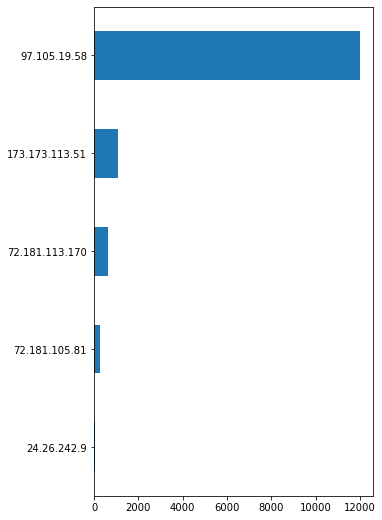

In [7]:
# Barplot of the counts of the ip addresses
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

### Create Dataframe for IP address statuses

In [8]:
# Gets the status codes for all ip addresses using and resets the index to 
# default index and gets the ip's frequency for each status
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [9]:
# Returns rows without status code 200  
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


In [10]:
# Returns rows with probabilities less than 100%
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

### Create dataframe using IP timestamps

In [11]:
# Gets timestamps for all ip addresses and resets the index to default index 
# and gets the ip's frequency for each status
timestamp_ip = (
    df.groupby('ip')
    .timestamp.value_counts(normalize=True)
    .rename('proba_timestamp_ip')
    .reset_index()
)
timestamp_ip

,ip,timestamp,proba_timestamp_ip
0,173.173.113.51,17/Apr/2019 03:26:28,0.002833
1,173.173.113.51,17/Apr/2019 04:35:29,0.002833
2,173.173.113.51,17/Apr/2019 04:45:15,0.002833
3,173.173.113.51,17/Apr/2019 04:46:09,0.002833
4,173.173.113.51,17/Apr/2019 04:52:46,0.002833
...,...,...,...
10038,97.105.19.58,17/Apr/2019 12:55:00,0.000083
10039,97.105.19.58,17/Apr/2019 12:55:01,0.000083
10040,97.105.19.58,17/Apr/2019 12:55:04,0.000083
10041,97.105.19.58,17/Apr/2019 12:55:08,0.000083


Gets Counts and Frequencies for specified column

In [12]:
# Assigns a variable name to df from using value_counts_and_frequencies func
timestamp_df = value_counts_and_frequencies(df.timestamp)
timestamp_df.head()

,count,proba
16/Apr/2019 19:56:10,9,0.000644
16/Apr/2019 19:49:58,8,0.000572
16/Apr/2019 20:01:30,7,0.000501
16/Apr/2019 20:12:23,6,0.000429
16/Apr/2019 20:02:59,6,0.000429


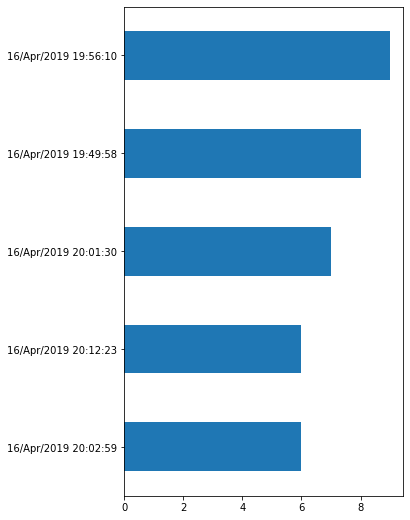

In [13]:
# Barplot of the counts of the timestamps
timestamp_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

### Create dataframe using IP timestamps

In [14]:
# Gets timestamps for all ip addresses and resets the index to default index 
# and gets the ip's frequency for each status
timestamp_ip = (
    df.groupby('ip')
    .timestamp.value_counts(normalize=True)
    .rename('proba_timestamp_ip')
    .reset_index()
)
timestamp_ip

,ip,timestamp,proba_timestamp_ip
0,173.173.113.51,17/Apr/2019 03:26:28,0.002833
1,173.173.113.51,17/Apr/2019 04:35:29,0.002833
2,173.173.113.51,17/Apr/2019 04:45:15,0.002833
3,173.173.113.51,17/Apr/2019 04:46:09,0.002833
4,173.173.113.51,17/Apr/2019 04:52:46,0.002833
...,...,...,...
10038,97.105.19.58,17/Apr/2019 12:55:00,0.000083
10039,97.105.19.58,17/Apr/2019 12:55:01,0.000083
10040,97.105.19.58,17/Apr/2019 12:55:04,0.000083
10041,97.105.19.58,17/Apr/2019 12:55:08,0.000083


Gets Counts and Frequencies for specified column

In [15]:
# Assigns a variable name to df from using value_counts_and_frequencies func
timestamp_df = value_counts_and_frequencies(df.timestamp)
timestamp_df.head()

,count,proba
16/Apr/2019 19:56:10,9,0.000644
16/Apr/2019 19:49:58,8,0.000572
16/Apr/2019 20:01:30,7,0.000501
16/Apr/2019 20:12:23,6,0.000429
16/Apr/2019 20:02:59,6,0.000429


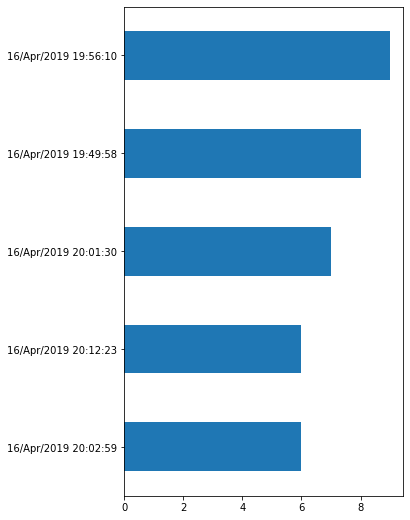

In [16]:
# Barplot of the counts of the timestamps
timestamp_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

### Create dataframe using IP request methods

In [17]:
# Gets request methods for all ip addresses and resets the index to default index 
# and gets the ip's frequency for each status
request_method_ip = (
    df.groupby('ip')
    .request_method.value_counts(normalize=True)
    .rename('proba_request_method_ip')
    .reset_index()
)
request_method_ip

,ip,request_method,proba_request_method_ip
0,173.173.113.51,GET,1.0
1,24.26.242.9,GET,1.0
2,3.88.129.158,GET,1.0
3,3.92.201.136,GET,1.0
4,34.207.64.242,GET,1.0
5,34.229.70.250,GET,1.0
6,35.174.209.2,GET,1.0
7,35.175.171.137,GET,1.0
8,45.23.250.16,GET,1.0
9,52.87.230.102,GET,1.0


Gets Counts and Frequencies for specified column

In [18]:
# Assigns a variable name to df from using value_counts_and_frequencies func
request_method_df = value_counts_and_frequencies(df.request_method)
request_method_df.head()

,count,proba
GET,13974,1.0


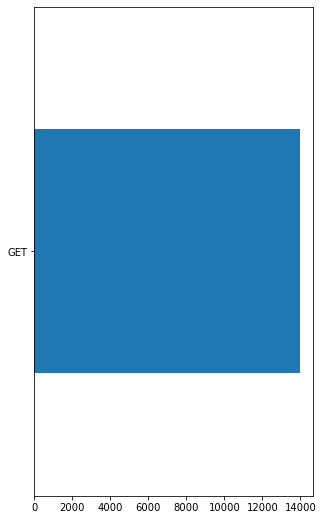

In [19]:
# Barplot of the counts of the request methods
request_method_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

### Create dataframe using IP request paths

In [20]:
# Gets request paths for all ip addresses and resets the index to default index 
# and gets the ip's frequency for each status
request_path_ip = (
    df.groupby('ip')
    .request_path.value_counts(normalize=True)
    .rename('proba_request_path_ip')
    .reset_index()
)
request_path_ip

,ip,request_path,proba_request_path_ip
0,173.173.113.51,/api/v1/items,0.060434
1,173.173.113.51,/api/v1/items?page=2,0.058546
2,173.173.113.51,/api/v1/items?page=3,0.058546
3,173.173.113.51,/api/v1/stores,0.050992
4,173.173.113.51,/api/v1/sales,0.007554
...,...,...,...
811,97.105.19.58,/api/v1/items?page=99999999999999999998,0.000083
812,97.105.19.58,/api/v1/stores?page=2,0.000083
813,97.105.19.58,/api/v1/stores?page=666,0.000083
814,97.105.19.58,/api/v1/stores?page=999,0.000083


Gets Counts and Frequencies for specified column

In [21]:
# Assigns a variable name to df from using value_counts_and_frequencies func
request_path_df = value_counts_and_frequencies(df.request_path)
request_path_df.head()

,count,proba
/api/v1/sales?page=2,709,0.050737
/api/v1/items,464,0.033205
/api/v1/items?page=2,291,0.020824
/api/v1/items?page=3,219,0.015672
/api/v1/stores,162,0.011593


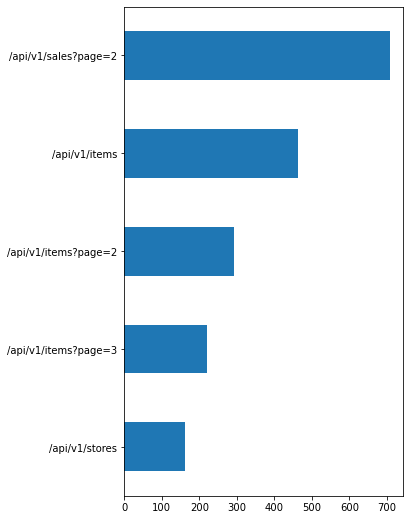

In [22]:
# Barplot of the counts of the request paths
request_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

### Create dataframe using IP http versions

In [23]:
# Gets request methods for all ip addresses and resets the index to default index 
# and gets the ip's frequency for each status
http_version_ip = (
    df.groupby('ip')
    .http_version.value_counts(normalize=True)
    .rename('proba_http_version_ip')
    .reset_index()
)
http_version_ip

,ip,http_version,proba_http_version_ip
0,173.173.113.51,HTTP/1.1,1.0
1,24.26.242.9,HTTP/1.1,1.0
2,3.88.129.158,HTTP/1.1,1.0
3,3.92.201.136,HTTP/1.1,1.0
4,34.207.64.242,HTTP/1.1,1.0
5,34.229.70.250,HTTP/1.1,1.0
6,35.174.209.2,HTTP/1.1,1.0
7,35.175.171.137,HTTP/1.1,1.0
8,45.23.250.16,HTTP/1.1,1.0
9,52.87.230.102,HTTP/1.1,1.0


Gets Counts and Frequencies for specified column

In [24]:
# Assigns a variable name to df from using value_counts_and_frequencies func
http_version_df = value_counts_and_frequencies(df.http_version)
http_version_df.head()

,count,proba
HTTP/1.1,13974,1.0


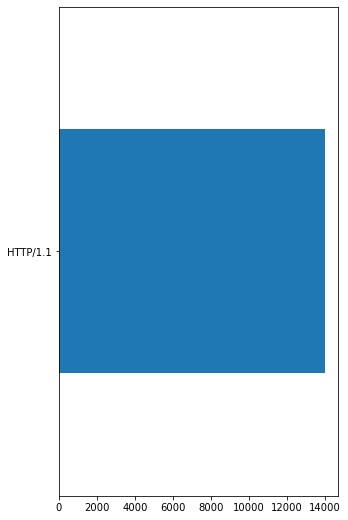

In [25]:
# Barplot of the counts of the http versions
http_version_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

### Create dataframe using IP user agents

In [34]:
# Gets user_agent for all ip addresses and resets the index to default index 
# and gets the ip's frequency for each status
user_agent_ip = (
    df.groupby('ip')
    .user_agent.value_counts(normalize=True)
    .rename('proba_user_agent_ip')
    .reset_index()
)
user_agent_ip

,ip,user_agent,proba_user_agent_ip
0,173.173.113.51,python-requests/2.21.0,1.000000
1,24.26.242.9,python-requests/2.21.0,1.000000
2,3.88.129.158,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.000000
3,3.92.201.136,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.000000
4,34.207.64.242,Slackbot 1.0 (+https://api.slack.com/robots),1.000000
5,34.229.70.250,Slackbot 1.0 (+https://api.slack.com/robots),1.000000
6,35.174.209.2,Slackbot 1.0 (+https://api.slack.com/robots),1.000000
7,35.175.171.137,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.000000
8,45.23.250.16,python-requests/2.21.0,1.000000
9,52.87.230.102,Slackbot 1.0 (+https://api.slack.com/robots),0.500000


Gets Counts and Frequencies for specified column

In [37]:
# Assigns a variable name to df from using value_counts_and_frequencies func
user_agent_df = value_counts_and_frequencies(df.user_agent)
user_agent_df.head(10)

,count,proba
python-requests/2.21.0,12001,0.858809
python-requests/2.20.1,1911,0.136754
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002433
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501
Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,0.000286
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,0.000143
Python-urllib/3.7,1,0.000072


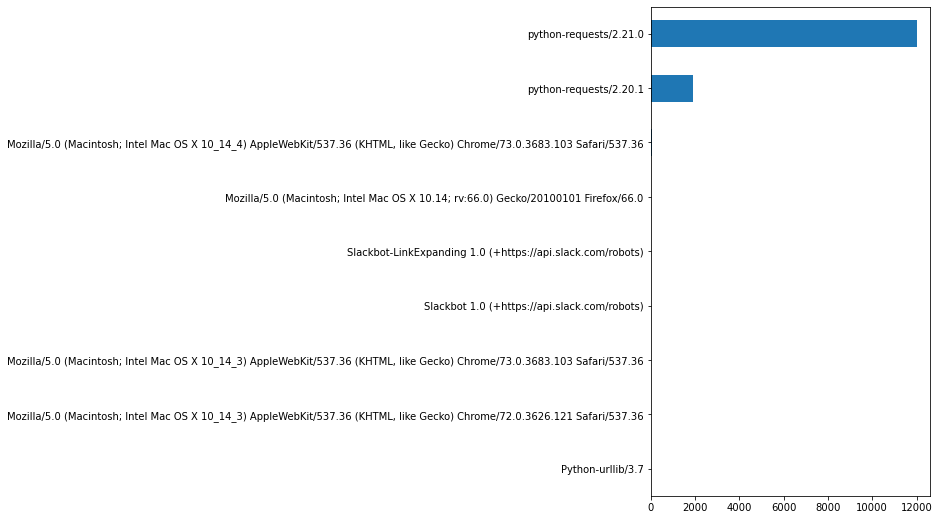

In [39]:
# Barplot of the counts of the request paths
user_agent_df['count'].sort_values().tail(9).plot.barh(figsize=(5, 9))
plt.show()

### Create dataframe using IP request paths

In [41]:
# Gets request paths for all ip addresses and resets the index to default index 
# and gets the ip's frequency for each status
size_ip = (
    df.groupby('ip')
    ['size'].value_counts(normalize=True)
    .rename('proba_size_ip')
    .reset_index()
)
size_ip

,ip,size,proba_size_ip
0,173.173.113.51,3561,0.060434
1,173.173.113.51,1787,0.058546
2,173.173.113.51,3659,0.058546
3,173.173.113.51,1328,0.050992
4,173.173.113.51,510134,0.013220
...,...,...,...
740,97.105.19.58,126,0.000083
741,97.105.19.58,278377,0.000083
742,97.105.19.58,327529,0.000083
743,97.105.19.58,343913,0.000083


Gets Counts and Frequencies for specified column

In [43]:
# Assigns a variable name to df from using value_counts_and_frequencies func
size_df = value_counts_and_frequencies(df['size'])
size_df.head()

,count,proba
494819,705,0.050451
3561,548,0.039216
3659,291,0.020824
1328,229,0.016388
1787,219,0.015672


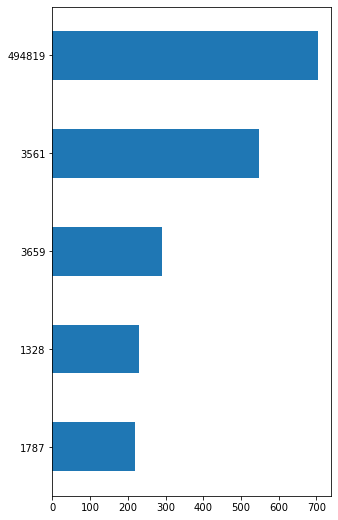

In [44]:
# Barplot of the counts of the request paths
size_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

# Summary
- The greatest anomalous requests appear to be in the address statuses and user agents